In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import xarray as xr
from pprint import pprint

# from FSSLibrary import FFTBasic as fft
import skyboxdatapy as skb

## Functions

In [25]:
def set_min_plot_prop(ax):
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    # plt.yticks(range(0,150,2))
    # ax.set_xlim(xmin, xmax)
    # plt.ylim(ymin, ymax)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()


## Define the cases

In [26]:
data_folder = "/home/shagun/Acads/SkyBox/ExpData/data_nosync"
testName1 = "Test248"

file1 = skb.io.find_unique_file(data_folder, testName1, ext="mat")
print(f"Processing file: {file1}")
loaded_mat1 = skb.io.load_case(file1)

skb.utils.print_test_properties(loaded_mat1)

Processing file: /home/shagun/Acads/SkyBox/ExpData/data_nosync/d1006/Measure_MAT/Test248_M_d60_R_H150_T100_R01.mat

=== Reading MAT ===
Top-level keys: ['ConversionFactor', 'DefaultData', 'MP3Filtered', 'TestProperties']
=== Successfully loaded using hdf5storage ===


=== Test Properties ===
   - testName: Test248
   - testType: MPL
   - repeatType: R1
   - useTest: nan
   - fSampling: 2048.0
   - calibrationFile: Test_d1024_Calib
   - depthAtWM: 0.603
   - depthAtMPL: 0.57
   - waveType: Regular
   - waveAmplitude: 0.15
   - wavePeriod: 1.0
   - focusingLocation: nan
   - remarks: Empty = Test136, GP1, GP2, GP3
=== End of Test Properties ===



In [27]:
testName2 = "Test250"

file2 = skb.io.find_unique_file(data_folder, testName2, ext="mat")
print(f"Processing file: {file2}")
loaded_mat2 = skb.io.load_case(file2)

skb.utils.print_test_properties(loaded_mat2)

Processing file: /home/shagun/Acads/SkyBox/ExpData/data_nosync/d1006/Measure_MAT/Test250_M_d60_R_H150_T100_R03.mat

=== Reading MAT ===
Top-level keys: ['ConversionFactor', 'DefaultData', 'MP3Filtered', 'TestProperties']
=== Successfully loaded using hdf5storage ===


=== Test Properties ===
   - testName: Test250
   - testType: MPL
   - repeatType: R3
   - useTest: nan
   - fSampling: 2048.0
   - calibrationFile: Test_d1024_Calib
   - depthAtWM: 0.605
   - depthAtMPL: 0.572
   - waveType: Regular
   - waveAmplitude: 0.15
   - wavePeriod: 1.0
   - focusingLocation: nan
   - remarks: Empty = Test136, GP1, GP2, GP3
=== End of Test Properties ===



## Extract Default Dataset and Set Tare

In [28]:
ds1 = loaded_mat1["DefaultData"]
print(ds1.attrs)

ds2 = loaded_mat2["DefaultData"]
print(ds2.attrs)

# Sometimes need to skip initial data.
# Skip first 10 indexes
ds1 = ds1.isel(Time=slice(10, None))
ds2 = ds2.isel(Time=slice(10, None))

# Set Tare for all probes
tare_tmin = 0
tare_tmax = 2
ds1 = skb.postprocess.set_all_probe_tare(ds1, start_time=tare_tmin, end_time=tare_tmax)
ds2 = skb.postprocess.set_all_probe_tare(ds2, start_time=tare_tmin, end_time=tare_tmax)

# Can also do a slice of time if needed here

pass

{'reference': 'MP3Filtered'}
{'reference': 'MP3Filtered'}


## Shift time coord to overlap signals

In [29]:
def get_timeidx_of_max(ds1, ds2, tmin, tmax):
    """Get time index of max value in both datasets in the given time range."""
    ds1_cut = ds1.sel(Time=slice(tmin, tmax))
    ds2_cut = ds2.sel(Time=slice(tmin, tmax))

    ds1_max_idxtime = ds1_cut.idxmax('Time')
    ds2_max_idxtime = ds2_cut.idxmax('Time')

    return ds1_max_idxtime, ds2_max_idxtime

In [30]:
ds1_max_idxtime, ds2_max_idxtime = get_timeidx_of_max(ds1, ds2, tmin=0, tmax=22)

# Shift ds2 time to align max of WG01
# Can change to any other probe as needed
tShift = ds2_max_idxtime['WG01'].values - ds1_max_idxtime['WG01'].values

ds2 = ds2.assign_coords(Time=ds2['Time'] - tShift)
ds2.attrs['TimeShiftApplied'] = tShift
print(f"Shifting ds2 by {ds2.attrs['TimeShiftApplied']}")

Shifting ds2 by -0.08589999999999876


## Plot signals

### WM Probe

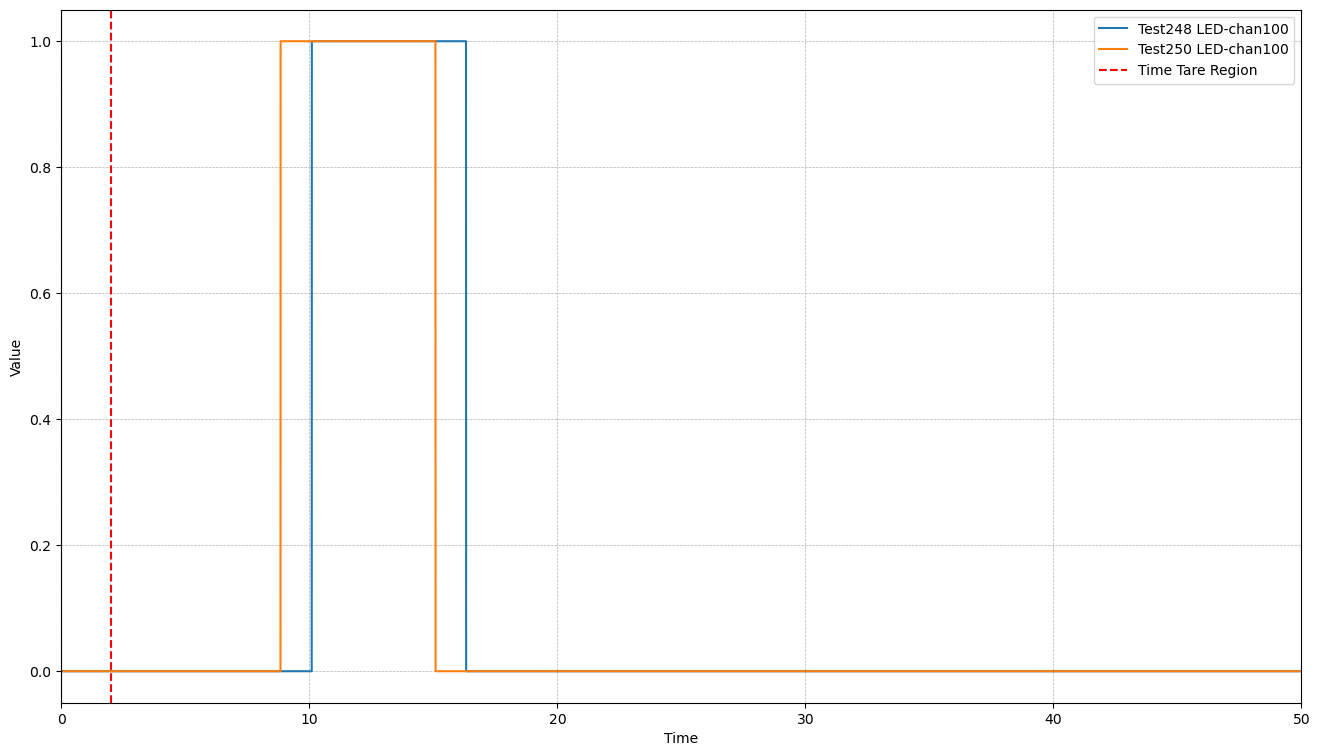

DS1 LED Transition Indices:
LED_time_0_to_1 = 10.0938
LED_time_1_to_0 = 16.3154
dt = 6.2216

DS2 LED Transition Indices:
LED_time_0_to_1 = 8.8349
LED_time_1_to_0 = 15.0825
dt = 6.2476


In [31]:
xmin = 0
xmax = 50


# fig, ax = plt.subplots(figsize=(16,9))
# ds1['WM'].plot(linestyle='-', label=f"{testName1} WM")
# ds2['WM'].plot(linestyle='-', label=f"{testName2} WM")
# ax.axvline(x=tare_tmin, color='r', linestyle='--')
# ax.axvline(x=tare_tmax, color='r', linestyle='--', label='Time Tare Region')
# # plt.yticks(range(0,150,2))
# ax.set_xlim(xmin, xmax)
# # plt.ylim(ymin, ymax)
# set_min_plot_prop(ax)
# plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['LED-chan100'].plot(linestyle='-', label=f"{testName1} LED-chan100")
ds2['LED-chan100'].plot(linestyle='-', label=f"{testName2} LED-chan100")
ax.axvline(x=tare_tmin, color='r', linestyle='--')
ax.axvline(x=tare_tmax, color='r', linestyle='--', label='Time Tare Region')
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

skb.postprocess.update_LED_transition_indices(ds1)
skb.postprocess.update_LED_transition_indices(ds2)

print("DS1 LED Transition Indices:")
print(f'LED_time_0_to_1 = {ds1.attrs["LED_time_0_to_1"]:.4f}')
print(f'LED_time_1_to_0 = {ds1.attrs["LED_time_1_to_0"]:.4f}')
print(f'dt = {ds1.attrs["LED_time_1_to_0"] - ds1.attrs["LED_time_0_to_1"]:.4f}')

print("\nDS2 LED Transition Indices:")
print(f'LED_time_0_to_1 = {ds2.attrs["LED_time_0_to_1"]:.4f}')
print(f'LED_time_1_to_0 = {ds2.attrs["LED_time_1_to_0"]:.4f}')
print(f'dt = {ds2.attrs["LED_time_1_to_0"] - ds2.attrs["LED_time_0_to_1"]:.4f}')

### WG01 - WG03

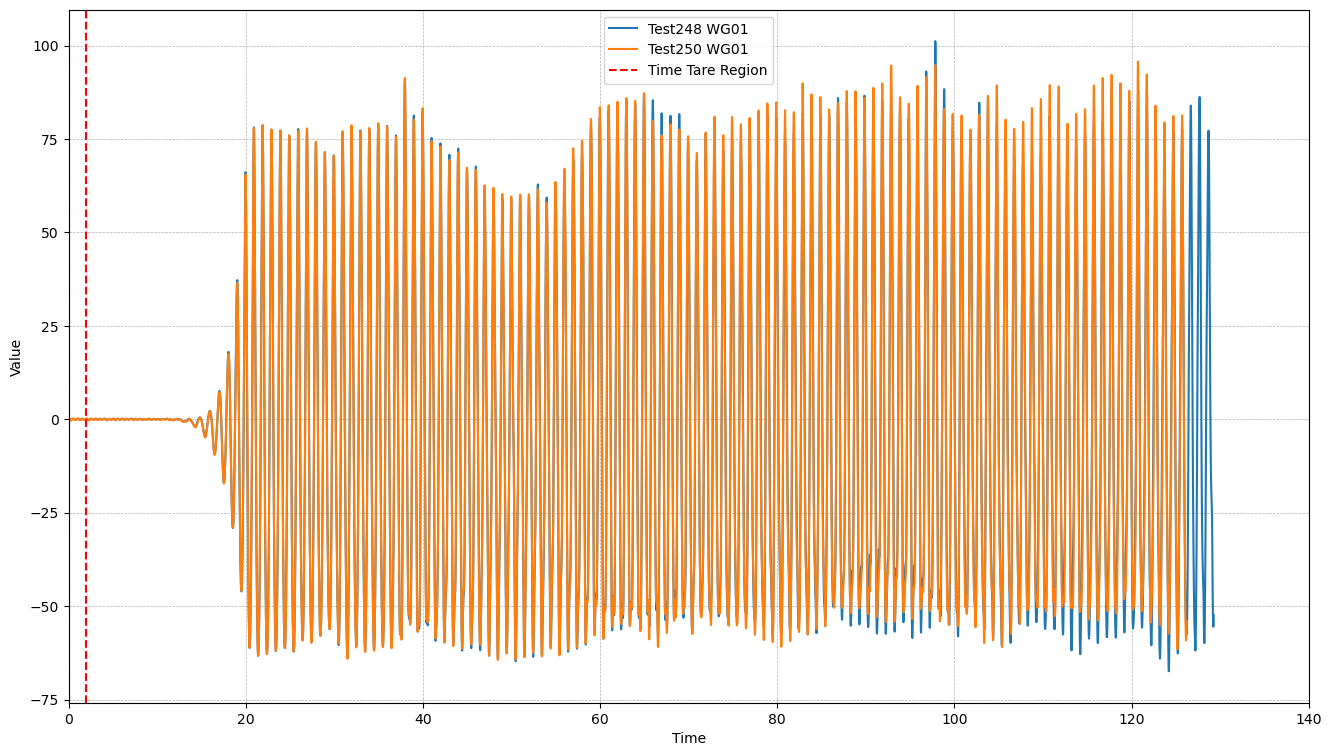

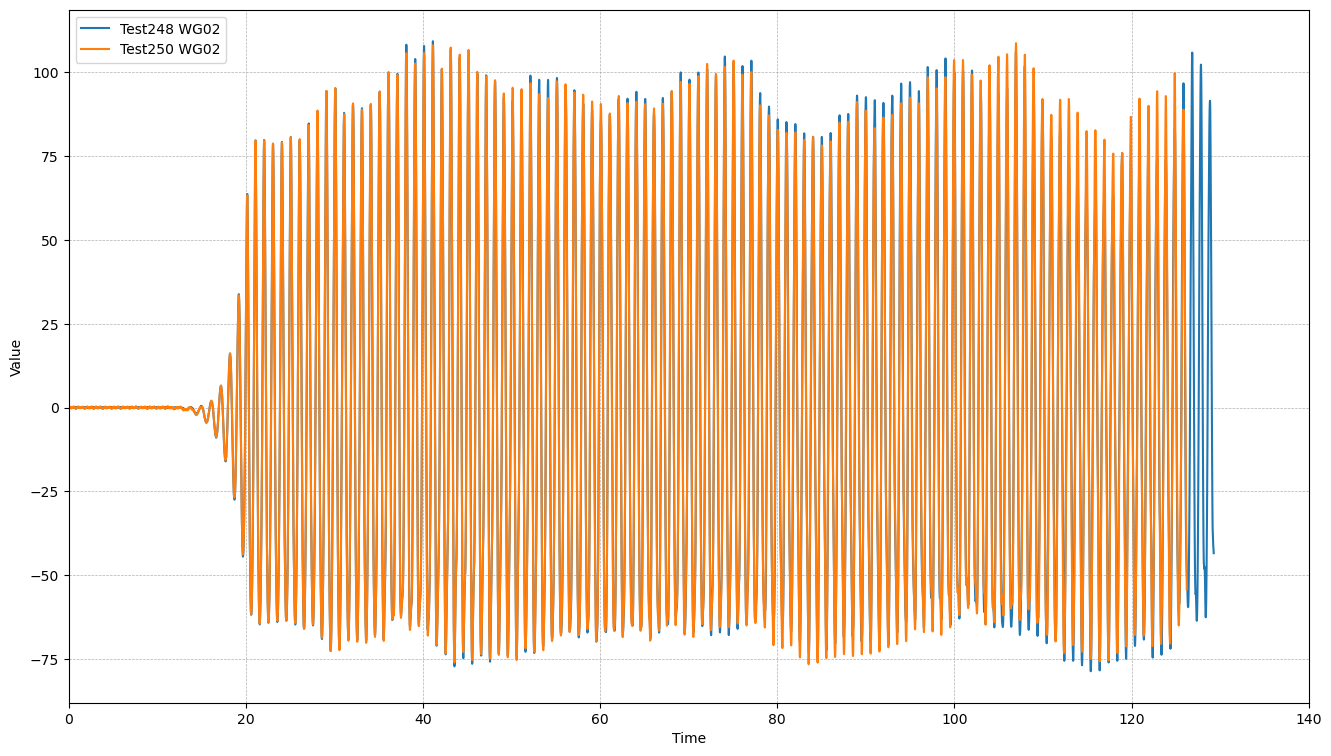

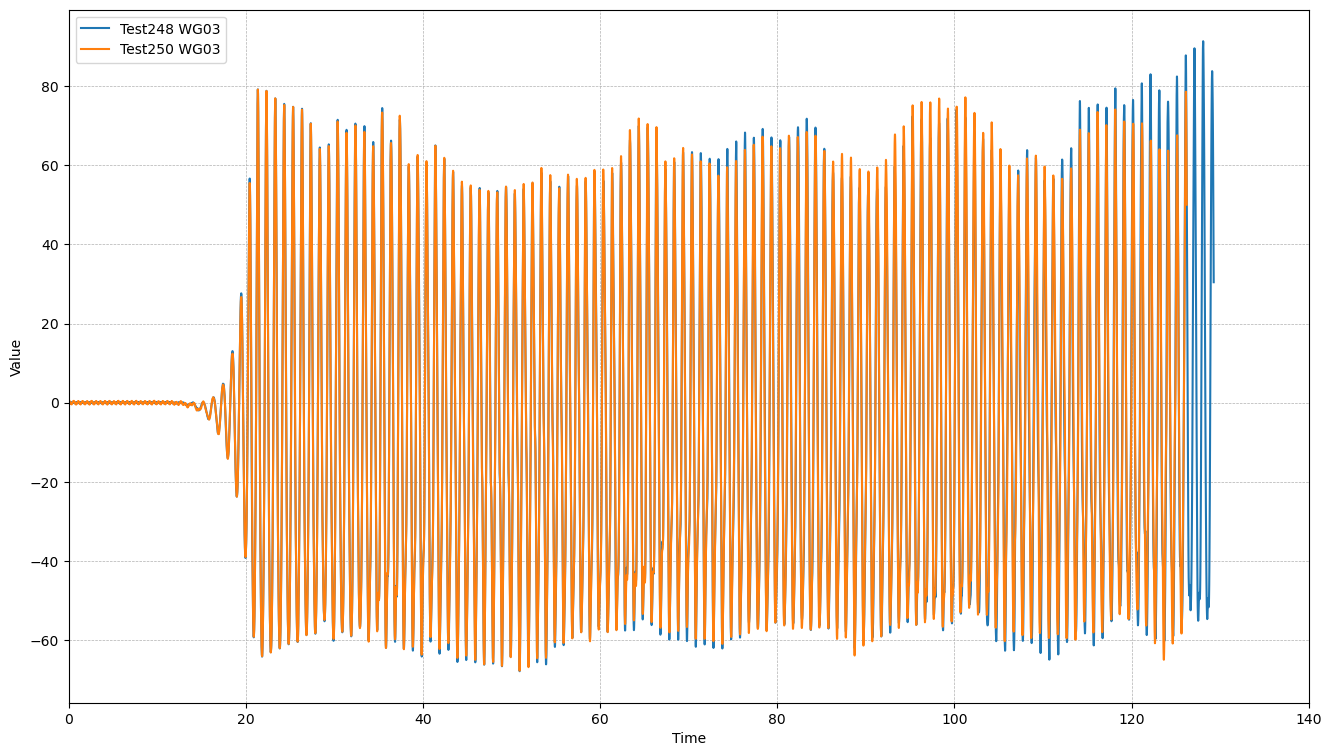

In [32]:
xmin = 0
xmax = 140

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG01'].plot(linestyle='-', label=f"{testName1} WG01")
ds2['WG01'].plot(linestyle='-', label=f"{testName2} WG01")
ax.axvline(x=tare_tmin, color='r', linestyle='--')
ax.axvline(x=tare_tmax, color='r', linestyle='--', label='Time Tare Region')
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG02'].plot(linestyle='-', label=f"{testName1} WG02")
ds2['WG02'].plot(linestyle='-', label=f"{testName2} WG02")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG03'].plot(linestyle='-', label=f"{testName1} WG03")
ds2['WG03'].plot(linestyle='-', label=f"{testName2} WG03")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

pass

### WG04 - WG06

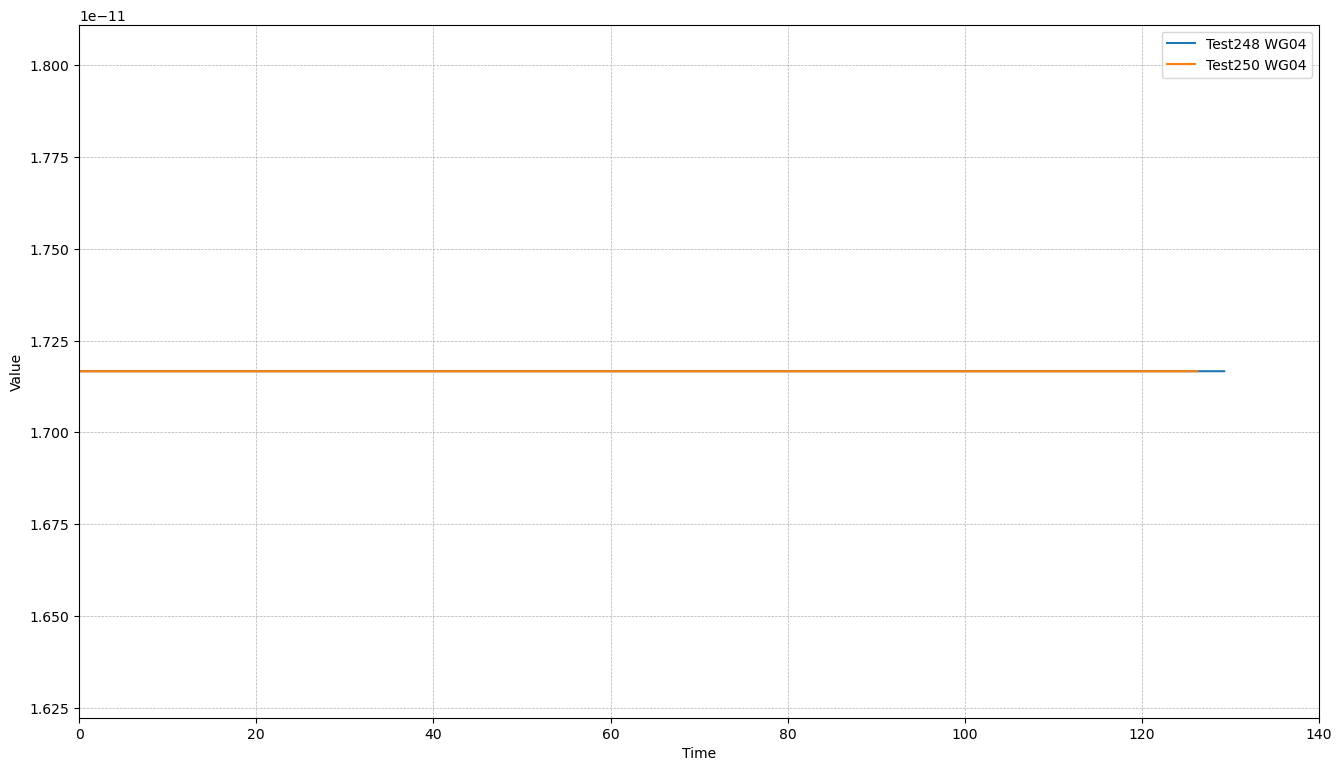

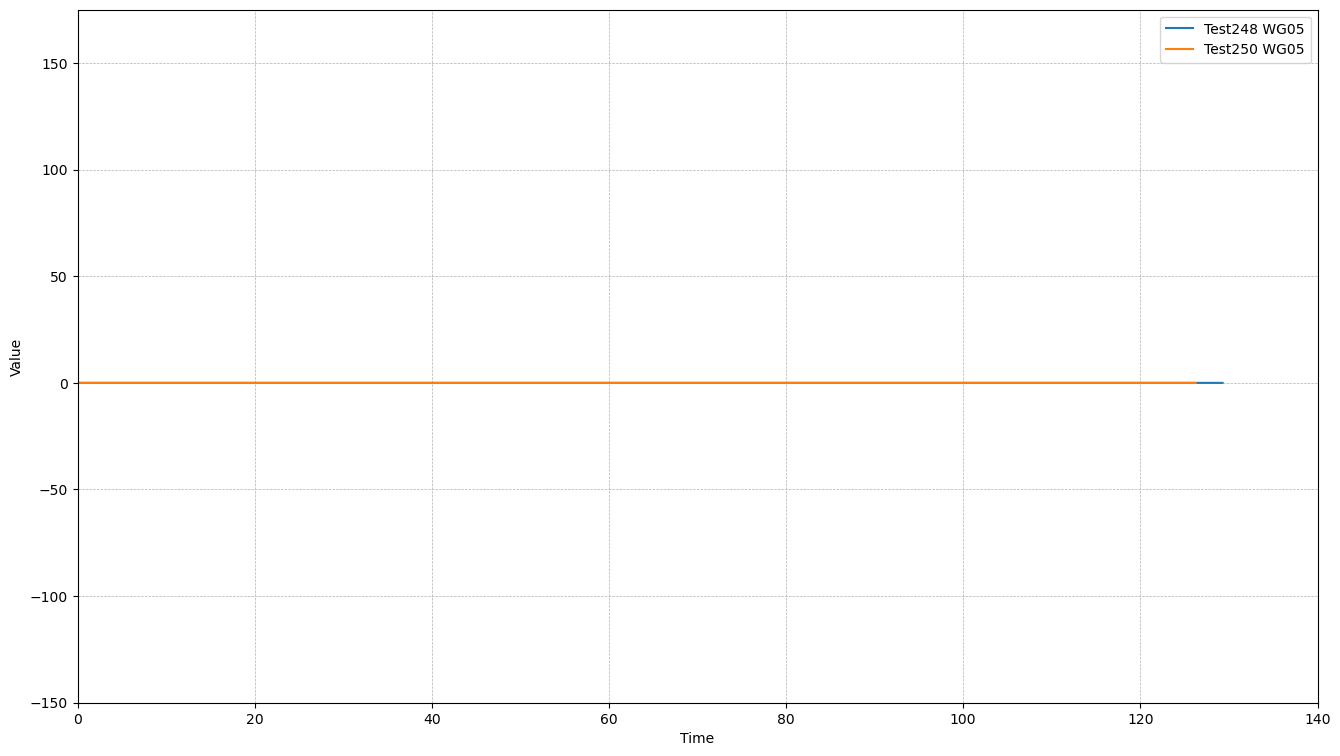

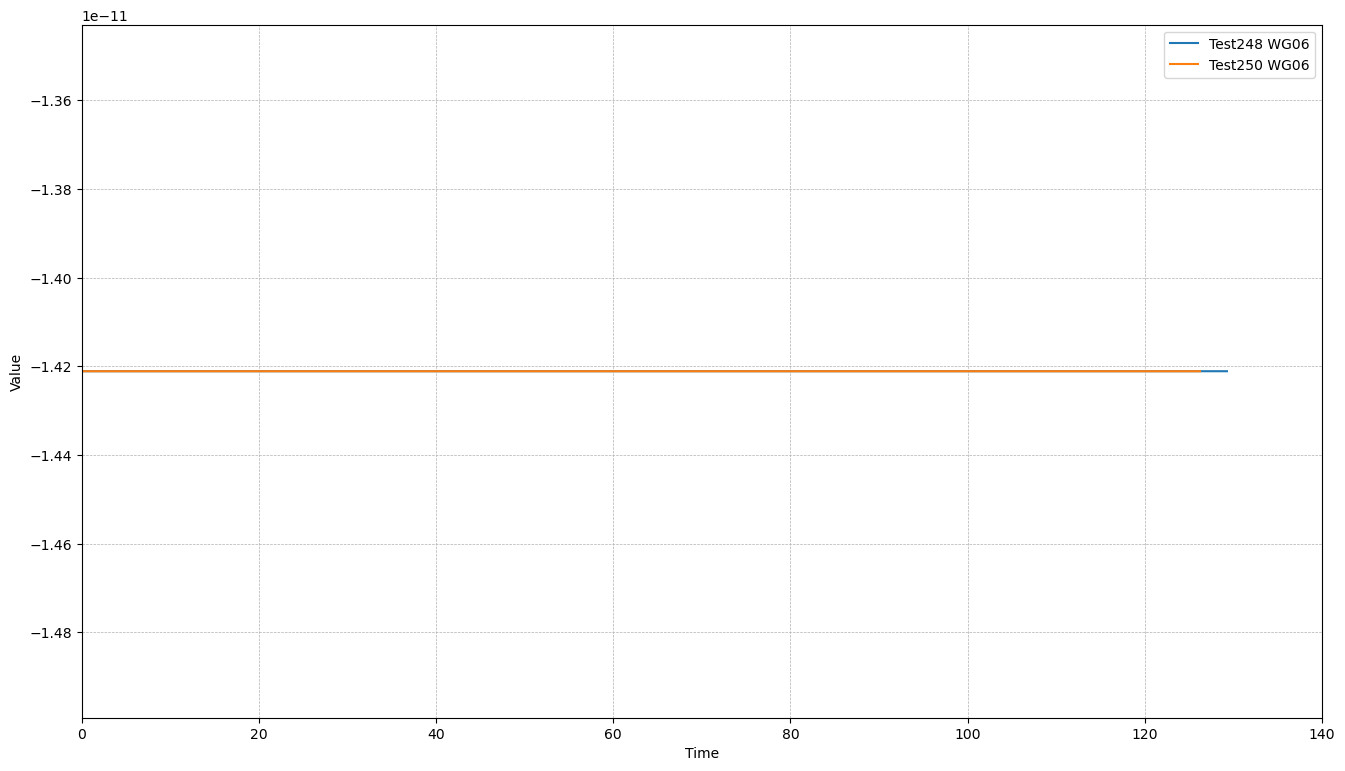

In [33]:
fig, ax = plt.subplots(figsize=(16,9))
ds1['WG04'].plot(linestyle='-', label=f"{testName1} WG04")
ds2['WG04'].plot(linestyle='-', label=f"{testName2} WG04")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG05'].plot(linestyle='-', label=f"{testName1} WG05")
ds2['WG05'].plot(linestyle='-', label=f"{testName2} WG05")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
plt.ylim(-150, 175)
set_min_plot_prop(ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG06'].plot(linestyle='-', label=f"{testName1} WG06")
ds2['WG06'].plot(linestyle='-', label=f"{testName2} WG06")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

pass

### WG07 - WG09

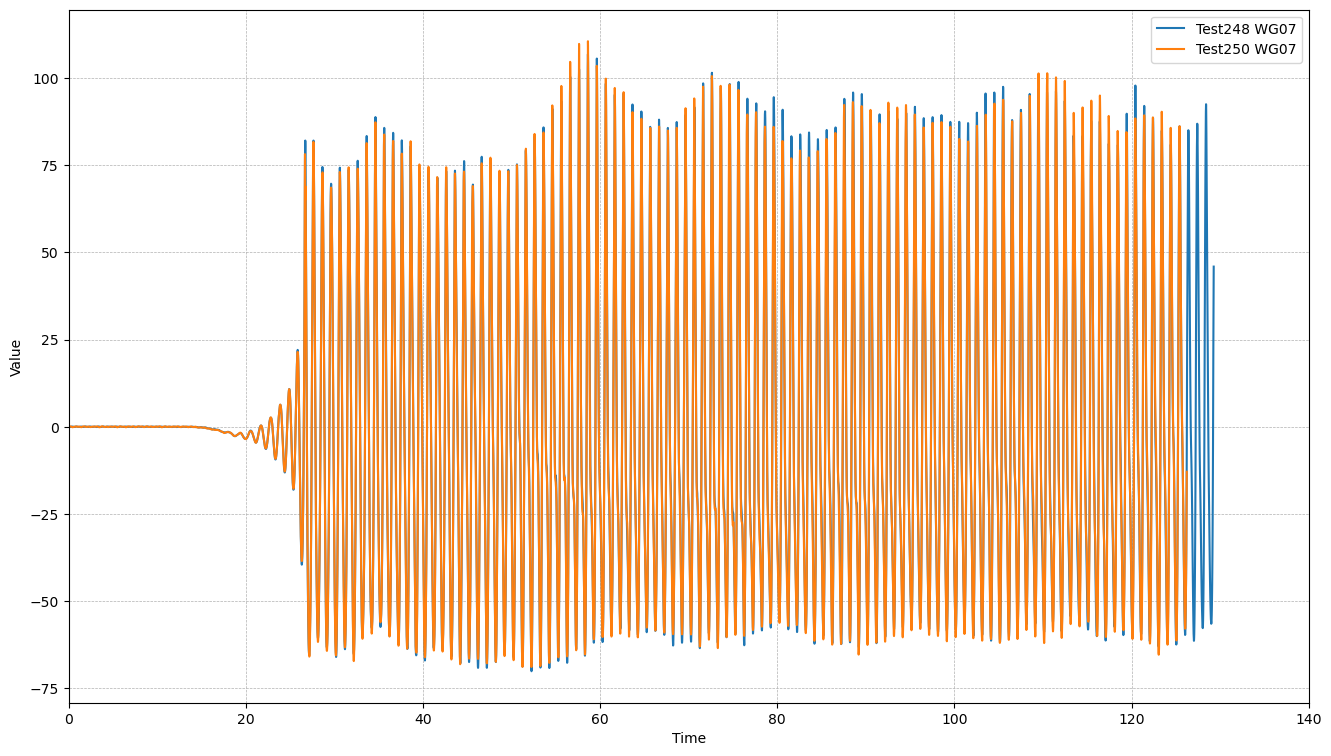

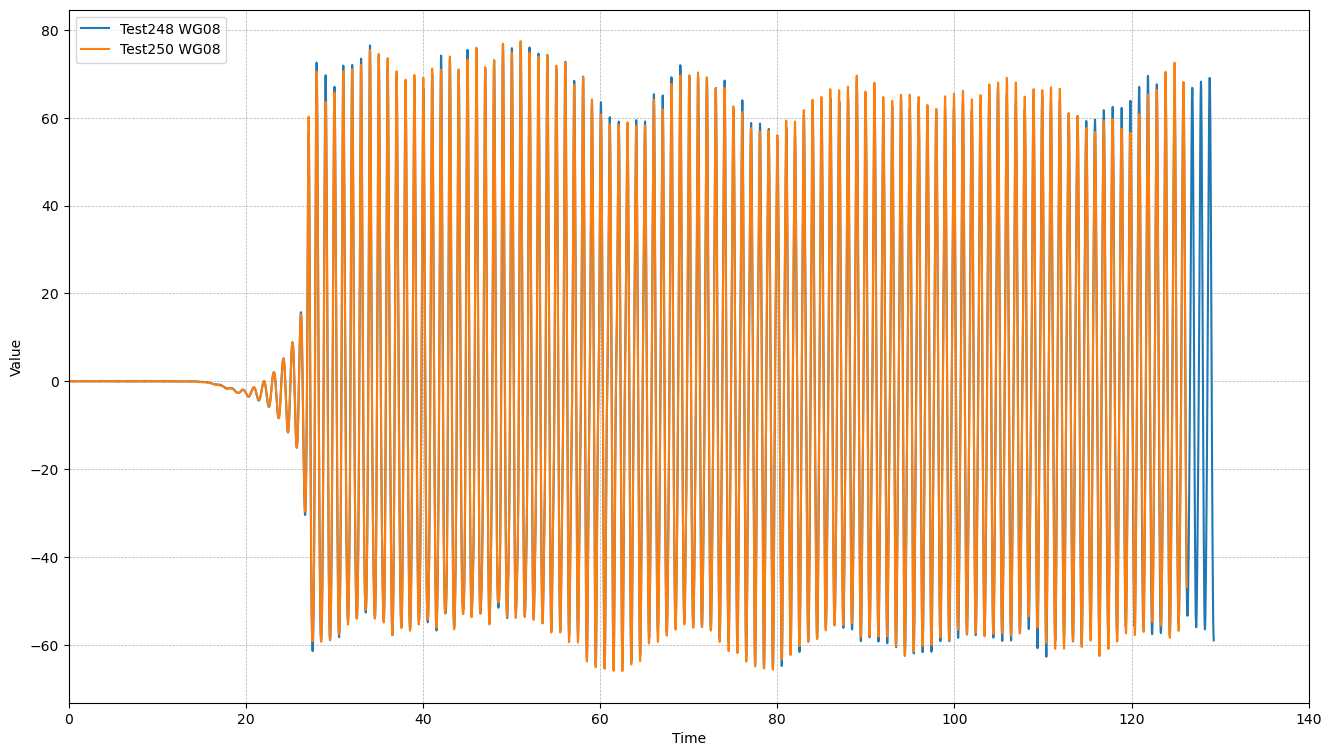

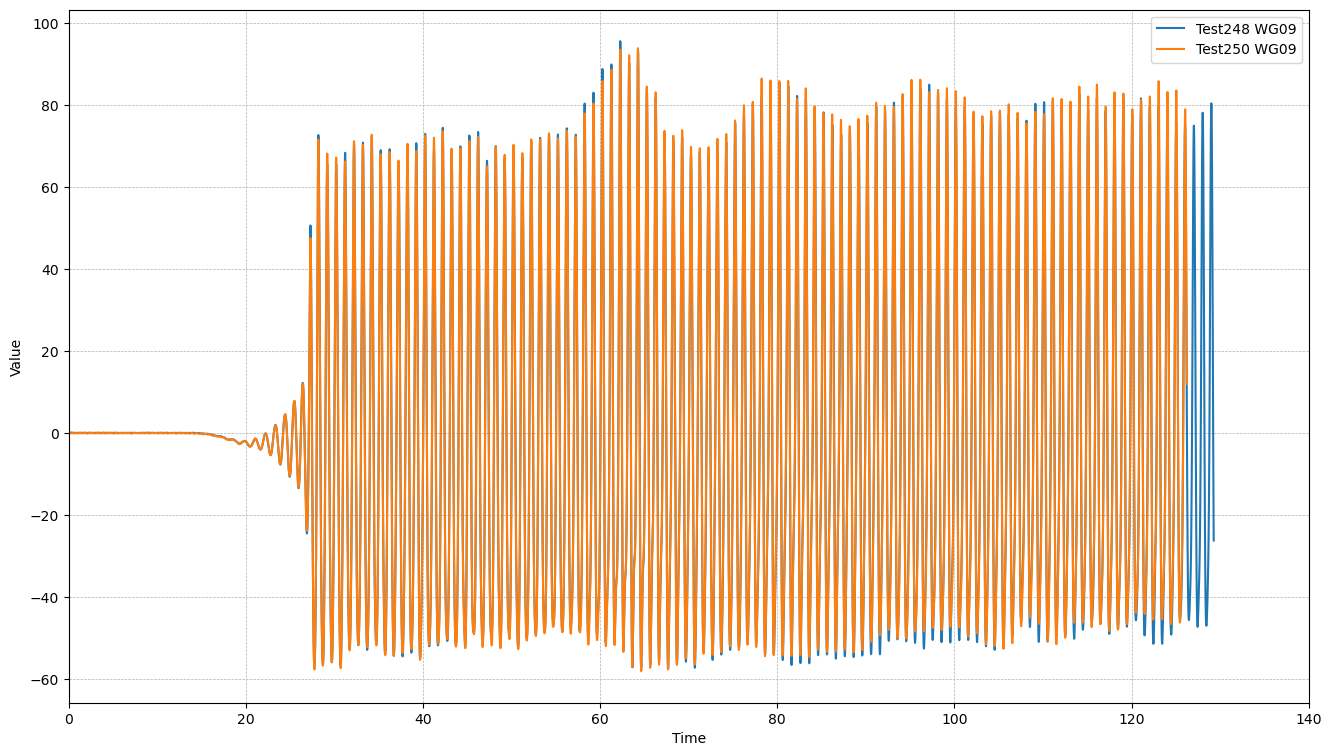

In [34]:
fig, ax = plt.subplots(figsize=(16,9))
ds1['WG07'].plot(linestyle='-', label=f"{testName1} WG07")
ds2['WG07'].plot(linestyle='-', label=f"{testName2} WG07")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG08'].plot(linestyle='-', label=f"{testName1} WG08")
ds2['WG08'].plot(linestyle='-', label=f"{testName2} WG08")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG09'].plot(linestyle='-', label=f"{testName1} WG09")
ds2['WG09'].plot(linestyle='-', label=f"{testName2} WG09")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

pass

## Find maxima

In [35]:
def print_min_max_all_signals(ds, probes=None):
    ds_min = ds.min('Time')
    ds_min_idxtime = ds.idxmin('Time')
    ds_max = ds.max('Time')
    ds_max_idxtime = ds.idxmax('Time')

    if probes is not None:
        vars_to_check = probes
    else:
        vars_to_check = ds.data_vars

    for var in vars_to_check:
        print(f"Signal: {var}", end=" ")        
        print(f"  Max Value: {ds_max[var].values} at : {ds_max_idxtime[var].values: .4f}", end=" ")
        print(f"  Min Value: {ds_min[var].values} at : {ds_min_idxtime[var].values: .4f}")
    

In [36]:
tmin = xmin
tmax = xmax

ds1_cut = ds1.sel(Time=slice(tmin, tmax))
ds2_cut = ds2.sel(Time=slice(tmin, tmax))

print("DS1 Signal Min/Max in selected time range:")
print_min_max_all_signals(ds1_cut)
print()

print("DS2 Signal Min/Max in selected time range:")
print_min_max_all_signals(ds2_cut)  

DS1 Signal Min/Max in selected time range:
Signal: WG01   Max Value: 101.17962991436261 at :  97.8477   Min Value: -67.42217008563739 at :  124.2100
Signal: WG02   Max Value: 109.23515551994127 at :  41.1245   Min Value: -78.61544448005873 at :  115.3980
Signal: WG03   Max Value: 91.30179554930268 at :  128.0890   Min Value: -67.82160445069732 at :  50.9160
Signal: WG04   Max Value: 1.716671249596402e-11 at :  0.0049   Min Value: 1.716671249596402e-11 at :  0.0049
Signal: WG05   Max Value: 9.549694368615746e-12 at :  0.0049   Min Value: 9.549694368615746e-12 at :  0.0049
Signal: WG06   Max Value: -1.4210854715202004e-11 at :  0.0049   Min Value: -1.4210854715202004e-11 at :  0.0049
Signal: WG07   Max Value: 106.8201221654025 at :  58.6284   Min Value: -70.0928778345975 at :  52.2539
Signal: WG08   Max Value: 77.31101118179598 at :  51.0400   Min Value: -65.39058881820404 at :  60.5176
Signal: WG09   Max Value: 95.5783309762662 at :  62.2817   Min Value: -57.387569023733796 at :  64.640

## Plot Spec

In [37]:
def getSpec(wg, fs, ax, xlim, lbl, fRef=1):    
    fHalf, fAmp, fS = skb.spec.get_single_sided_spectrum(wg, fs)

    
    ax.plot(fHalf/fRef, fAmp, label=lbl)
    ax.set_xlabel("Frequency f/fRef")
    ax.set_ylabel("Amplitude (mm)")
    ax.set_title("Single-Sided FFT")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()
    ax.set_xlim(xlim)
    # plt.show()

    return fHalf, fAmp, fS

Sample Len = 264758
Least count Hz = 0.007735365881295372
Max Freq (Half band) Hz = 1024.0
Sample Len = 258352
Least count Hz = 0.007927169133585186
Max Freq (Half band) Hz = 1024.0


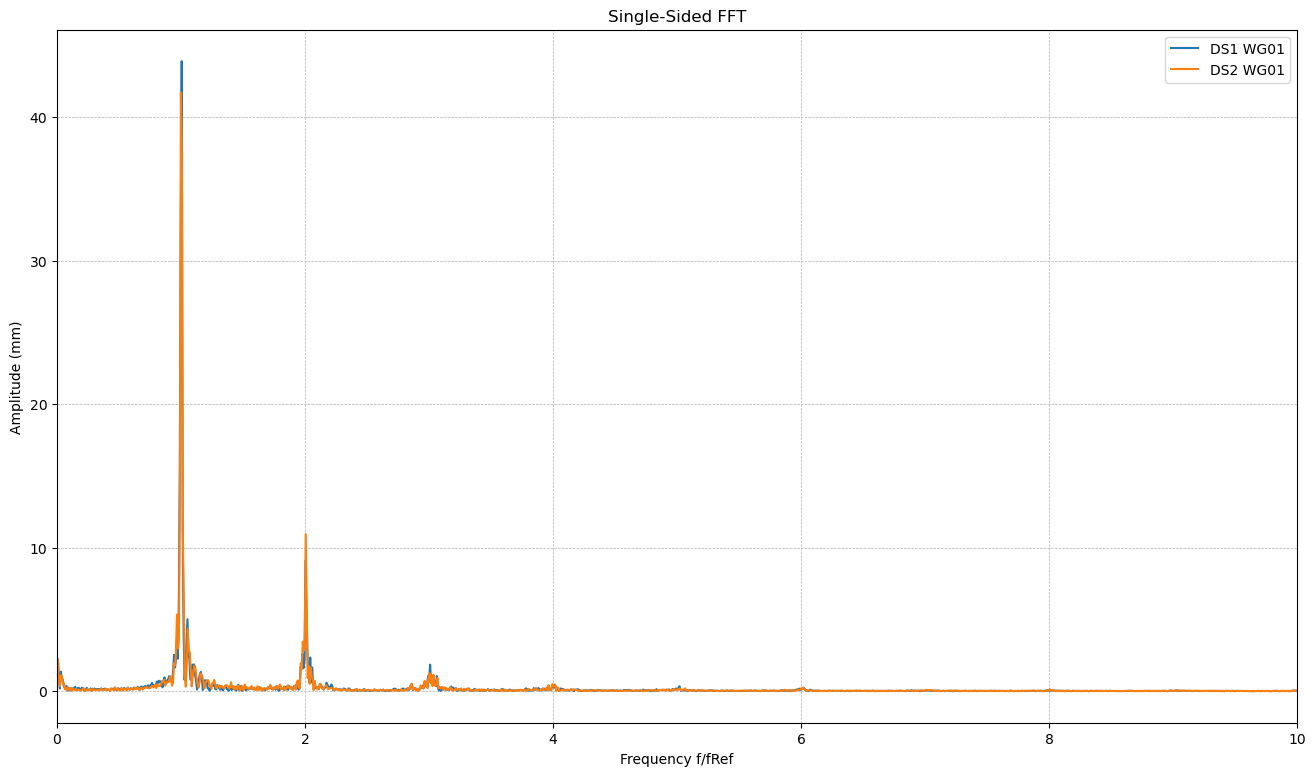

In [38]:
tmin = xmin
tmax = xmax

ds1_cut = ds1.sel(Time=slice(tmin, tmax))
ds2_cut = ds2.sel(Time=slice(tmin, tmax))

fSampling1 = loaded_mat1['TestProperties']['fSampling']
fSampling2 = loaded_mat2['TestProperties']['fSampling']

# Plot spectrum
fig, ax = plt.subplots(figsize=(16,9))
xlim = (0, 10)
getSpec(ds1_cut['WG01'], fSampling1, ax, xlim, "DS1 WG01")
# getSpec(ds1_cut['WG05'], fSampling1, ax, xlim, "DS1 WG05")
# getSpec(ds1_cut['WG07'], fSampling1, ax, xlim, "DS1 WG07")
getSpec(ds2_cut['WG01'], fSampling2, ax, xlim, "DS2 WG01")

pass